# Temperature - Stations

In [17]:
import autoroot
import ee
from tqdm.auto import tqdm
import numpy as np
import xarray as xr
import pandas as pd
import pint_xarray
from scipy.stats import rv_histogram, genextreme
# from bayesevt._src.geoprocessing.math import safe_reciprocal
from geo_toolz._src.masks.country import add_country_mask
from geo_toolz._src.masks.land import add_land_mask
from geo_toolz._src.masks.ocean import add_ocean_mask
from geo_toolz._src.validation.coords import validate_longitude, validate_latitude
from geo_toolz._src.encoders.time import time_rescale, time_unrescale
from geo_toolz._src.discretize.grid import RegularLonLat
from geo_toolz._src.data.reanalysis.gee import download_era5_gee
from geo_toolz.extremes import calculate_block_maxima_ts, calculate_pot_quantile, calculate_pot_ts, calculate_pp_counts_ts, calculate_pp_stats_ts
from odc.geo.geobox import GeoBox
from odc.geo.geom import Geometry
from odc.geo.crs import CRS
import dask
import jax
import jax.random as jrandom
import jax.numpy as jnp
from jaxtyping import Array, Float
from tensorflow_probability.substrates.jax import distributions as tfd
from numpyro.infer.autoguide import AutoDelta
from jaxtyping import Float, Array

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import xarray as xr
import regionmask

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%config InlineBackend.figure_format = 'retina'
# plt.style.use(
#     "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
# )

# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# cluster.dashboard_link

## Elevation Maps

In [19]:
!ls /pool/usuarios/juanjohn/data/observations

1850-2024.csv			stations_info_tx_v29.0e.txt
elev_ens_0.1deg_reg_v29.0e.nc	tg_ens_mean_0.1deg_reg_v29.0e.nc
elev_ens_0.25deg_reg_v29.0e.nc	tg_ens_mean_0.25deg_reg_v29.0e.nc
HadCRUT5.0Analysis_gl.txt	tmp.rar
stations_info_qq_v29.0e.txt	tx_ens_mean_0.1deg_reg_v29.0e.nc
stations_info_tg_v29.0e.txt	tx_ens_mean_0.25deg_reg_v29.0e.nc


In [20]:
ds_elev = xr.open_dataset("/pool/usuarios/juanjohn/data/observations/elev_ens_0.1deg_reg_v29.0e.nc", engine="netcdf4")
ds_elev = validate_longitude(validate_latitude(ds_elev))
ds_elev = add_country_mask(ds_elev, "Spain").where(ds_elev.spain_mask==1, drop=True)
ds_elev

<xarray.Dataset> Size: 59kB
Dimensions:     (lat: 77, lon: 123)
Coordinates:
  * lon         (lon) float64 984B -9.25 -9.15 -9.05 -8.95 ... 2.75 2.85 2.95
  * lat         (lat) float64 616B 36.05 36.15 36.25 36.35 ... 43.45 43.55 43.65
    spain_mask  (lat, lon) int16 19kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    region      int64 8B 132
    abbrevs     <U3 12B 'E'
    names       <U16 64B 'Spain'
Data variables:
    elevation   (lat, lon) float32 38kB nan nan nan nan nan ... nan nan nan nan
Attributes:
    References:     http://surfobs.climate.copernicus.eu//dataaccess/access_e...
    E-OBS_version:  v29.0e
    Conventions:    CF-1.4CF-1.4

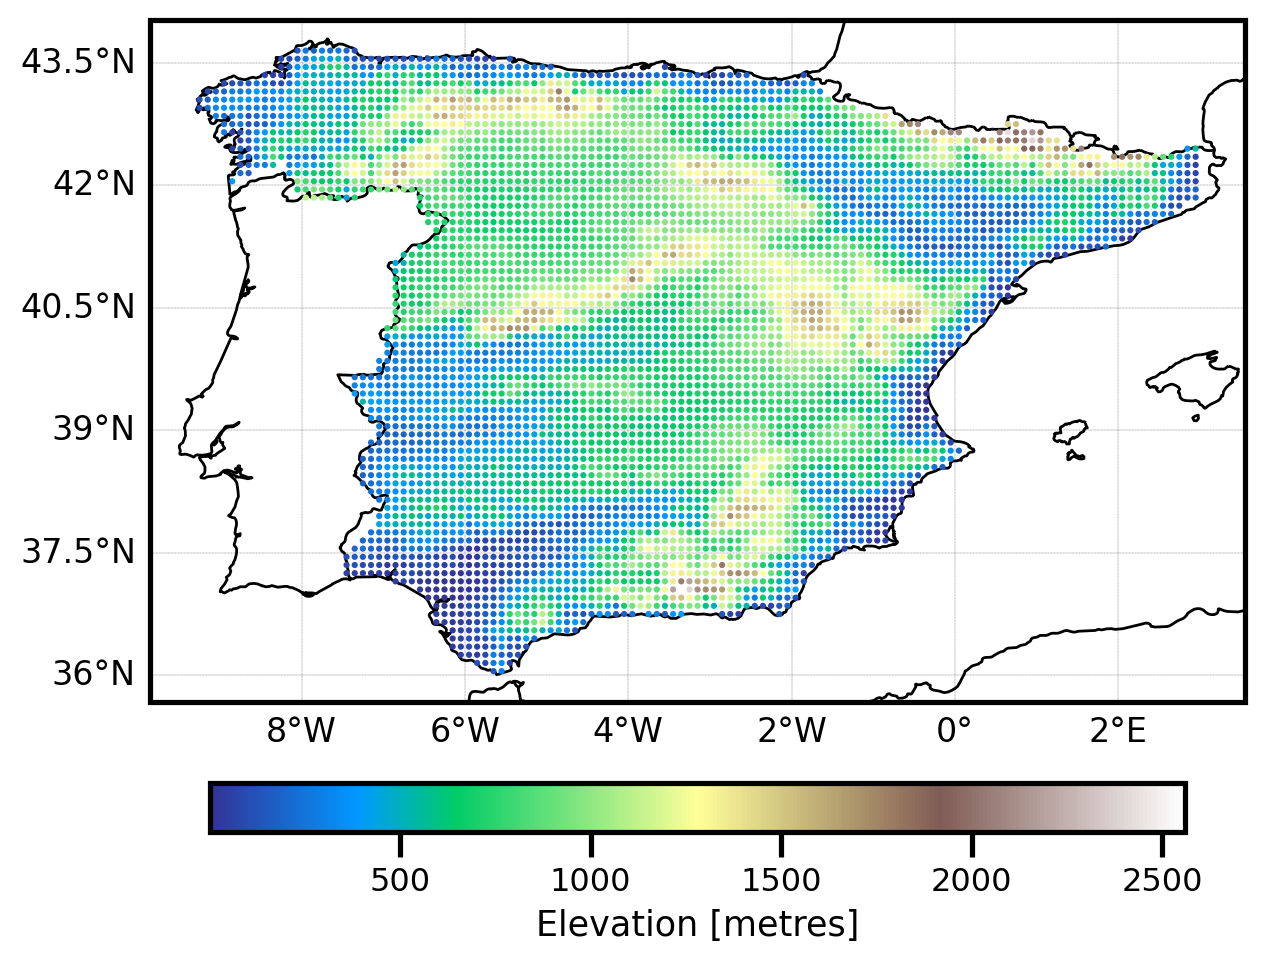

In [21]:



fig, ax = plt.subplots(figsize=(10,5), subplot_kw={'projection': ccrs.PlateCarree()})

cbar_kwargs = {
    "fraction": 0.06, 
    "pad": 0.1, 
    "orientation": "horizontal",
}


ax.add_feature(cf.COASTLINE, linewidth=1)
ax.add_feature(cf.BORDERS, linewidth=1)
ax.set(aspect="equal")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12} 

ds_elev.plot.scatter(
    ax=ax,
    x="lon", y="lat", hue="elevation", s=5.0, 
    marker="o",
    edgecolors=None, 
    linewidths=0.001, 
    zorder=2,
    cmap="terrain", 
    cbar_kwargs=cbar_kwargs
)
ax.set(title="")

plt.tight_layout()
plt.show()
plt.show()

## Global Mean Surface Temperature

* HadCRUT (Climate Research Unite & Met Office Hadley Centre) - [Link](https://crudata.uea.ac.uk/cru/data/temperature/)
* GISS (NASA) - [Link](https://data.giss.nasa.gov/gistemp/)
* BEST (Berkeley Earth System) - [Link](https://berkeleyearth.org/data/)
* GWI (Global Warming Index) - [Link](https://www.globalwarmingindex.org/)
> A diferencia de las anteriores, representa directamente el efecto de las actividades humanas (Greenhouse Gases) en la temperatura promedio global, ya que la serie está obtenida con simulaciones de modelos climáticos globales. El problema es que no se actualiza con frecuencia


***

[**HadCRUT**](https://crudata.uea.ac.uk/cru/data/temperature/)

> Combined land [CRUTEM5] and marine [HadSST4] temperature anomalies on a 5° by 5° grid with greater geographical coverage via statistical infilling (Morice et al., 2021)

```bash
wget https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT.5.0.2.0.analysis.anomalies.ensemble_mean.nc
```

***

[**HadSST4**](https://crudata.uea.ac.uk/cru/data/temperature/)

> Sea surface temperature anomalies on a 5° by 5° grid (Kennedy et al., 2019)

```bash
wget https://crudata.uea.ac.uk/cru/data/temperature/HadSST.4.0.1.0_median.nc
```


**TODO** - Download the Global Mean

In [8]:
ds_t2m_anom = xr.open_dataset("/pool/usuarios/juanjohn/data/bayesevt/raw/observations/HadCRUT.5.0.2.0.analysis.anomalies.ensemble_mean.nc", engine="netcdf4")
ds_t2m_anom = validate_longitude(validate_latitude(ds_t2m_anom))
ds_t2m_anom

<xarray.Dataset> Size: 43MB
Dimensions:           (time: 2089, lat: 36, lon: 72, bnds: 2)
Coordinates:
  * time              (time) datetime64[ns] 17kB 1850-01-16T12:00:00 ... 2024...
  * lat               (lat) float64 288B -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * lon               (lon) float64 576B -177.5 -172.5 -167.5 ... 172.5 177.5
    realization       int64 8B ...
Dimensions without coordinates: bnds
Data variables:
    tas_mean          (time, lat, lon) float64 43MB ...
    time_bnds         (time, bnds) datetime64[ns] 33kB ...
    latitude_bnds     (lat, bnds) float64 576B ...
    longitude_bnds    (lon, bnds) float64 1kB ...
    realization_bnds  (bnds) int64 16B ...
Attributes:
    comment:      2m air temperature over land blended with sea water tempera...
    history:      Data set built at: 2024-02-27T15:32:53+00:00
    institution:  Met Office Hadley Centre / Climatic Research Unit, Universi...
    licence:      HadCRUT5 is licensed under the Open Government Licence v3.0...
    reference:    C. P. Morice, J. J. Kennedy, N. A. Rayner, J. P. Winn, E. H...
    source:       CRUTEM.5.0.2.0 HadSST.4.0.1.0
    title:        HadCRUT.5.0.2.0 blended land air temperature and sea-surfac...
    version:      HadCRUT.5.0.2.0
    Conventions:  CF-1.7

In [9]:
def weighted_spatial_mean(ds):
    lat = ds["lat"]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    return (ds * weight).mean(dim=["lat", "lon"])

ds_t2m_anom_mu = weighted_spatial_mean(ds_t2m_anom.tas_mean)

In [10]:
ds_t2m_anom_mu.time

<xarray.DataArray 'time' (time: 2089)> Size: 17kB
array(['1850-01-16T12:00:00.000000000', '1850-02-15T00:00:00.000000000',
       '1850-03-16T12:00:00.000000000', ..., '2023-11-16T00:00:00.000000000',
       '2023-12-16T12:00:00.000000000', '2024-01-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 17kB 1850-01-16T12:00:00 ... 2024-01-1...
    realization  int64 8B 100
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
    long_name:      time

In [11]:
!pwd

/home/juanjohn/projects/dynev4eo/notebooks/0_download


In [12]:
df = pd.read_csv(
    "/home/juanjohn/projects/bayesevt/notebooks/evt/models/unconditional/spatial_field/GST_1750_2022.txt",
    sep='\s+', index_col=0
)
df = df.set_index(pd.to_datetime(df.index, format="%Y"))
df.index = df.index.rename("time")

In [13]:
df

,GWI,HadCRUT,GISS,BEST
time,,,,
1750-01-01,-0.376651,NaN,NaN,NaN
1751-01-01,-0.377904,NaN,NaN,NaN
1752-01-01,-0.378680,NaN,NaN,NaN
1753-01-01,-0.379838,NaN,NaN,NaN
1754-01-01,-0.381503,NaN,NaN,NaN
...,...,...,...,...
2018-01-01,0.822262,0.840,0.85,0.871
2019-01-01,0.850067,0.968,0.98,1.008
2020-01-01,0.878821,1.000,1.02,1.035


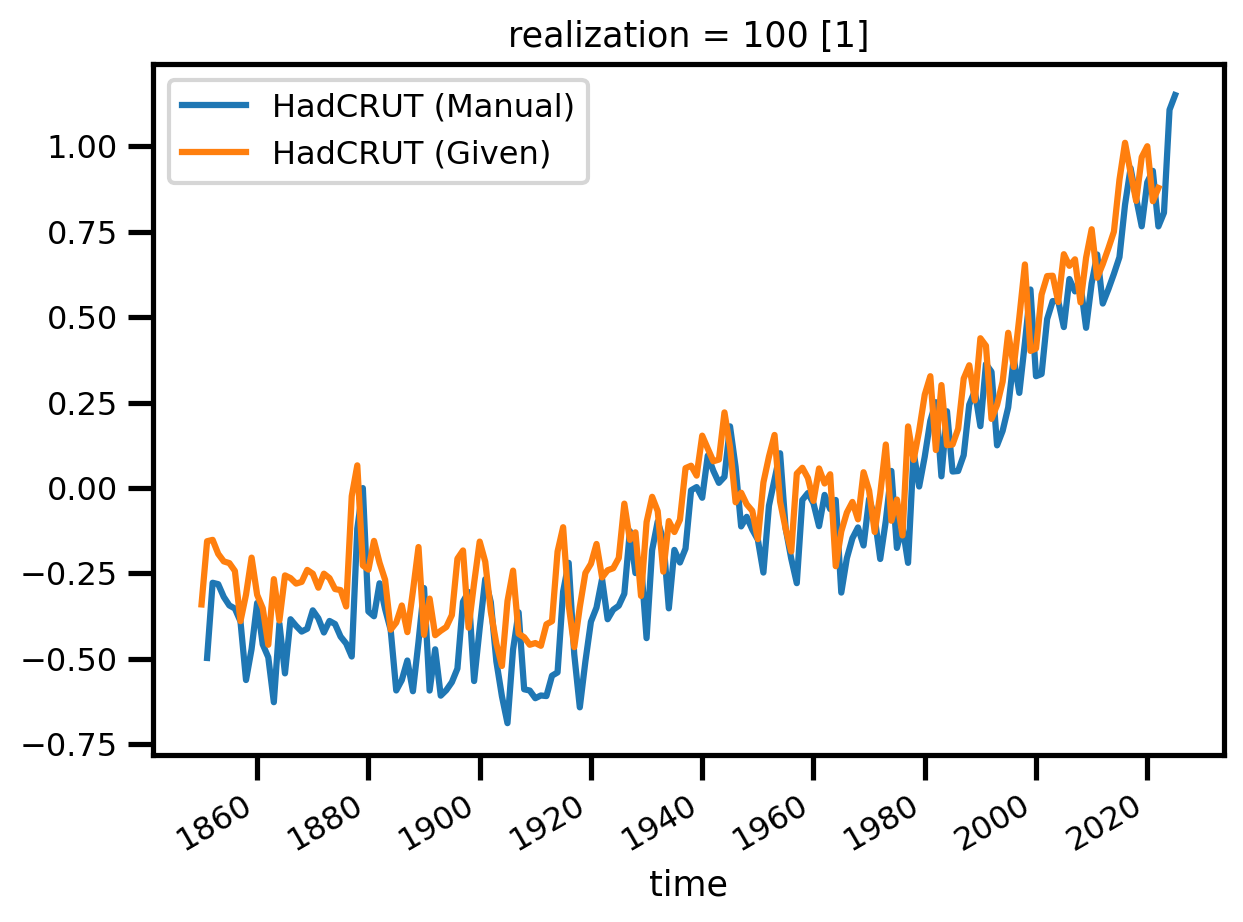

In [14]:
fig, ax = plt.subplots()
ds_t2m_anom_mu.resample(time="1YE").mean().plot(ax=ax, label="HadCRUT (Manual)")
df.plot(y="HadCRUT", ax=ax, label="HadCRUT (Given)")

plt.legend()
plt.tight_layout()
plt.show()

In [16]:
ds_gmst_year = df.to_xarray()
ds_gmst_year

<xarray.Dataset> Size: 11kB
Dimensions:  (time: 273)
Coordinates:
  * time     (time) datetime64[ns] 2kB 1750-01-01 1751-01-01 ... 2022-01-01
Data variables:
    GWI      (time) float64 2kB -0.3767 -0.3779 -0.3787 ... 0.8788 nan nan
    HadCRUT  (time) float64 2kB nan nan nan nan nan ... 0.968 1.0 0.839 0.878
    GISS     (time) float64 2kB nan nan nan nan nan ... 0.85 0.98 1.02 0.85 0.89
    BEST     (time) float64 2kB nan nan nan nan nan ... 1.008 1.035 0.882 0.921

In [19]:
ds_gmst_year.to_netcdf("/pool/usuarios/juanjohn/data/bayesevt/clean/observations/gmst_global.nc", engine="netcdf4")

In [21]:
df = df.set_index(pd.to_datetime(df.index.values))

In [24]:
df.index

DatetimeIndex(['1970-01-01 00:00:00.000001750',
               '1970-01-01 00:00:00.000001751',
               '1970-01-01 00:00:00.000001752',
               '1970-01-01 00:00:00.000001753',
               '1970-01-01 00:00:00.000001754',
               '1970-01-01 00:00:00.000001755',
               '1970-01-01 00:00:00.000001756',
               '1970-01-01 00:00:00.000001757',
               '1970-01-01 00:00:00.000001758',
               '1970-01-01 00:00:00.000001759',
               ...
               '1970-01-01 00:00:00.000002013',
               '1970-01-01 00:00:00.000002014',
               '1970-01-01 00:00:00.000002015',
               '1970-01-01 00:00:00.000002016',
               '1970-01-01 00:00:00.000002017',
               '1970-01-01 00:00:00.000002018',
               '1970-01-01 00:00:00.000002019',
               '1970-01-01 00:00:00.000002020',
               '1970-01-01 00:00:00.000002021',
               '1970-01-01 00:00:00.000002022'],
              dtype=